In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn
import os
from pathlib import Path

# Scikit-learn Utilities
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Note: train_test_split sudah tidak dibutuhkan lagi

# Konfigurasi Tampilan
%matplotlib inline
sns.set_style('whitegrid')

current_dir = Path(os.getcwd()) 
PROJECT_DIR = current_dir.parents[2] # Naik 3 level ke root project

# --- 1. LOKASI DATA BARU (Anti-Leakage) ---
# Mengarah ke folder hasil split manual (processed_correct)
DATA_DIR = PROJECT_DIR / 'data' / 'processed_correct'
TRAIN_FILE = DATA_DIR / 'train_features.csv'
TEST_FILE  = DATA_DIR / 'test_features.csv'
MLRUNS_DIR = PROJECT_DIR / 'mlruns' 

print(f"📂 Posisi Notebook: {current_dir}")
print(f"📂 Project Root   : {PROJECT_DIR}")
print(f"📂 MLflow Path    : {MLRUNS_DIR}")
print(f"📄 Train File     : {TRAIN_FILE}")
print(f"📄 Test File      : {TEST_FILE}")

# --- 2. SETUP MLFLOW ---
if not MLRUNS_DIR.exists():
    MLRUNS_DIR.mkdir(parents=True, exist_ok=True)

mlflow.set_tracking_uri(f"file:///{MLRUNS_DIR.as_posix()}")
mlflow.set_experiment("Roodio_Mood_RF_Experiment_LeakageFree")

# --- 3. LOAD DATA (TRAIN & TEST TERPISAH) ---
if not TRAIN_FILE.exists() or not TEST_FILE.exists():
    print(f"\n[ERROR] File CSV tidak ditemukan di: {DATA_DIR}")
    print("Pastikan Anda sudah menjalankan script '3_extract_features.py' sebelumnya.")
    raise FileNotFoundError("Dataset Training/Testing hilang!")

# Baca Data
df_train = pd.read_csv(TRAIN_FILE)
df_test  = pd.read_csv(TEST_FILE)

print(f"\n📊 Data Train: {df_train.shape}")
print(f"📊 Data Test : {df_test.shape} (Unseen Data)")

# --- 4. PREPROCESSING ---
# Hapus kolom label dan filename (jika ada)
drop_cols = ['label']
if 'filename' in df_train.columns:
    drop_cols.append('filename')

X_train = df_train.drop(columns=drop_cols, errors='ignore')
y_train_raw = df_train['label']

X_test = df_test.drop(columns=drop_cols, errors='ignore')
y_test_raw = df_test['label']

# Encode Label
# PENTING: Fit pada Training, Transform pada Testing
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test  = le.transform(y_test_raw)

label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
print(f"✅ Label Mapping: {label_mapping}")
print("✅ Setup Selesai. Siap Training (Tanpa Leakage).")

📂 Posisi Notebook: c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\src\models\audioModel
📂 Project Root   : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning
📂 MLflow Path    : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\mlruns
📄 Train File     : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\data\processed_correct\train_features.csv
📄 Test File      : c:\CAWU4GROUP3\projects\projectRoodio\machineLearning\data\processed_correct\test_features.csv

📊 Data Train: (1601, 158)
📊 Data Test : (156, 158) (Unseen Data)
✅ Label Mapping: {0: 'angry', 1: 'happy', 2: 'relaxed', 3: 'sad'}
✅ Setup Selesai. Siap Training (Tanpa Leakage).


🚀 Sedang Melatih Random Forest (Tunggu sebentar)...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Training Selesai!
🏆 Parameter Terbaik : {'classifier__max_depth': 10, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
📊 Akurasi Final     : 0.6090
⚖️ F1-Score (Macro)  : 0.6063


2026/02/02 22:14:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\andiz\anaconda3\envs\roodio-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


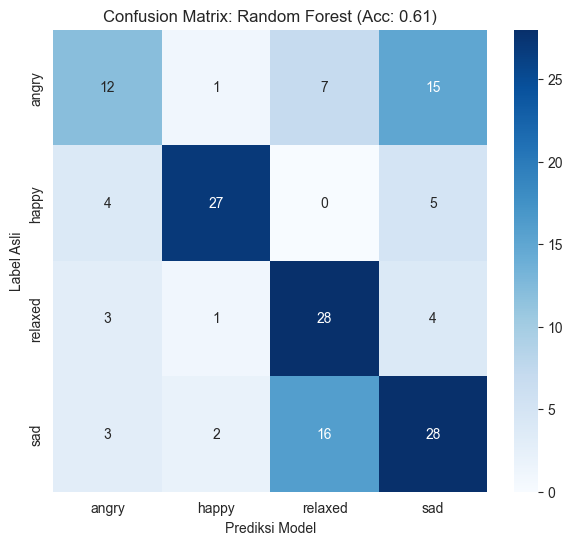

💾 Model, metrik lengkap, report.txt, dan gambar CM tersimpan di MLflow.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score 

# --- 1. DEFINISI MODEL & PIPELINE ---
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# --- 2. GRID SEARCH PARAMETER ---
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],      
    'classifier__max_depth': [None, 10, 20],         
    'classifier__min_samples_split': [2, 5]          
}

# --- 3. EKSEKUSI TRAINING (DENGAN MLFLOW) ---
run_name = "RF_Tuning_Notebook"

with mlflow.start_run(run_name=run_name):
    print("🚀 Sedang Melatih Random Forest (Tunggu sebentar)...")
    
    # Grid Search
    grid = GridSearchCV(pipeline_rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    
    # --- 4. EVALUASI ---
    best_model = grid.best_estimator_
    best_params = grid.best_params_
    
    y_pred = best_model.predict(X_test)
    
    # Hitung Metrik Utama
    test_acc = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred, average='macro')       # <--- BARU
    test_prec = precision_score(y_test, y_pred, average='macro') # <--- BARU
    test_recall = recall_score(y_test, y_pred, average='macro')  # <--- BARU
    
    print(f"\n✅ Training Selesai!")
    print(f"🏆 Parameter Terbaik : {best_params}")
    print(f"📊 Akurasi Final     : {test_acc:.4f}")
    print(f"⚖️ F1-Score (Macro)  : {test_f1:.4f}") # Print biar kelihatan di layar
    
    # --- 5. LOGGING KE MLFLOW (LENGKAP) ---
    # A. Log Parameter
    clean_params = {k.replace("classifier__", ""): v for k, v in best_params.items()}
    mlflow.log_params(clean_params)
    
    # B. Log Metrik (Sekarang lebih banyak)
    metrics = {
        "accuracy": test_acc,
        "f1_macro": test_f1,
        "precision_macro": test_prec,
        "recall_macro": test_recall
    }
    mlflow.log_metrics(metrics) # <--- Log sekaligus
    
    # C. Log Classification Report sebagai File Teks (Artifact)
    # Ini trik pro: simpan laporan lengkap jadi file txt biar bisa dibuka di MLflow UI
    report_text = classification_report(y_test, y_pred, target_names=le.classes_)
    with open("classification_report.txt", "w") as f:
        f.write(report_text)
    mlflow.log_artifact("classification_report.txt")
    
    # Hapus file lokal setelah upload agar bersih
    if os.path.exists("classification_report.txt"):
        os.remove("classification_report.txt")

    # D. Log Model
    signature = mlflow.models.infer_signature(X_train, best_model.predict(X_train))
    mlflow.sklearn.log_model(
        sk_model=best_model,
        artifact_path="model",
        signature=signature,
        input_example=X_train.iloc[:1]
    )
    
    # --- 6. VISUALISASI CONFUSION MATRIX ---
    plt.figure(figsize=(7,6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: Random Forest (Acc: {test_acc:.2f})')
    plt.ylabel('Label Asli')
    plt.xlabel('Prediksi Model')
    
    # Simpan gambar CM ke MLflow juga
    plt.savefig("confusion_matrix.png")
    mlflow.log_artifact("confusion_matrix.png")
    plt.show()
    
    # Hapus file gambar lokal
    if os.path.exists("confusion_matrix.png"):
        os.remove("confusion_matrix.png")
        
    print("💾 Model, metrik lengkap, report.txt, dan gambar CM tersimpan di MLflow.")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# --- EVALUASI MENDALAM ---
print("\n" + "="*40)
print("📊 LAPORAN EVALUASI MODEL")
print("="*40)

# 1. Classification Report (Mencakup Precision, Recall, F1)
report = classification_report(y_test, y_pred, target_names=le.classes_)
print(report)

# 2. Metrik Global Spesifik
macro_f1 = f1_score(y_test, y_pred, average='macro')
macro_prec = precision_score(y_test, y_pred, average='macro')

print("-" * 40)
print(f"🏆 Macro F1-Score : {macro_f1:.4f} (Keseimbangan performa antar kelas)")
print(f"🎯 Macro Precision: {macro_prec:.4f} (Tingkat kepercayaan prediksi)")
print("-" * 40)

# 3. Analisis Kesalahan (Confusion Matrix Interpretation)
cm = confusion_matrix(y_test, y_pred)
np.fill_diagonal(cm, 0) 
max_error_idx = np.unravel_index(np.argmax(cm), cm.shape)
true_label_err = le.classes_[max_error_idx[0]]
pred_label_err = le.classes_[max_error_idx[1]]
count_err = cm[max_error_idx]

print(f"⚠️ KESALAHAN TERBESAR MODEL:")
print(f"Model paling sering salah mengira '{true_label_err}' sebagai '{pred_label_err}'")
print(f"Jumlah kejadian: {count_err} kali.")
print("Analisis: Kemungkinan fitur audio kedua mood ini memiliki kemiripan (High Arousal/Low Valence).")


📊 LAPORAN EVALUASI MODEL
              precision    recall  f1-score   support

       angry       0.55      0.34      0.42        35
       happy       0.87      0.75      0.81        36
     relaxed       0.55      0.78      0.64        36
         sad       0.54      0.57      0.55        49

    accuracy                           0.61       156
   macro avg       0.63      0.61      0.61       156
weighted avg       0.62      0.61      0.60       156

----------------------------------------
🏆 Macro F1-Score : 0.6063 (Keseimbangan performa antar kelas)
🎯 Macro Precision: 0.6260 (Tingkat kepercayaan prediksi)
----------------------------------------
⚠️ KESALAHAN TERBESAR MODEL:
Model paling sering salah mengira 'sad' sebagai 'relaxed'
Jumlah kejadian: 16 kali.
Analisis: Kemungkinan fitur audio kedua mood ini memiliki kemiripan (High Arousal/Low Valence).
